In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from os.path import join
from threading import Thread
import time
import gc

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.layers import Conv2D, Input, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, ZeroPadding2D, Cropping2D
from keras.losses import binary_crossentropy
from keras.models import load_model
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras.backend as K

from scipy import misc

from anti.keras_helper import returnTransferedImages

Using TensorFlow backend.


In [4]:
### Settings ###
input_folder = '../input'
# List to all images
train_masks = join(input_folder, 'train_masks.csv')
# Location of train images
x_input = join(input_folder, 'train')
# Location of train masks
y_input = join(input_folder, 'train_masks')
# Image dimensions
img_w = 1918 #1918
img_h = 1280 #1280
# Define view of car used for training
angles = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
# Variable for dice_coef
smooth = 1

In [5]:
def ret_angle_list(x_list, angle):
    angle = '_' + angle
    k = [x.find(angle) for x in x_list['img']]
    k = np.array(k)
    
    k[k>0] = 1
    k[k<0] = 0
    
    k = [i if x==1 else None for i,x in enumerate(k)]
    k = [value for value in k if value != None]
    k = pd.DataFrame([x_list['img'][i] for i in k], columns=['img'])
    return k

def remove_obj_rti(obj):
    gc.collect()
    del obj.obj
    del obj.queue
    del obj
    gc.collect()

In [6]:
df_img_id = pd.read_csv(train_masks, usecols=['img'])
df_img_id['img'] = df_img_id['img'].str.split('.').str[0]

In [7]:
data_gen_args_train = dict(zca_epsilon=0,
                          featurewise_center=True,
                          featurewise_std_normalization=True)
datagen_train = ImageDataGenerator(**data_gen_args_train)

datagen_train.std = np.array([[[ 58.49208069,  58.91231155,  58.01151657]]], dtype=np.float32)
datagen_train.mean = np.array([[[ 111.84810638,  111.84810638,  111.84810638]]], dtype=np.float32)
datagen_train.augment = True

In [8]:
# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def buildModel():
    
    ip = Input(shape=(img_h, img_w, 3))

    a = Conv2D(12, 3, padding='same') (ip)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    a = Conv2D(12, 3, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    a = MaxPooling2D(pool_size=2) (a)

    a = Conv2D(24, 3, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    a = Conv2D(24, 3, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    a = MaxPooling2D(pool_size=2) (a)
    
    a = Conv2D(32, 3, dilation_rate=1, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    
    a = Conv2D(32, 3, dilation_rate=1, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)

    a = Conv2D(32, 3, dilation_rate=2, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)

    a = Conv2D(32, 3, dilation_rate=4, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)

    a = Conv2D(32, 3, dilation_rate=8, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)

    a = Conv2D(32, 3, dilation_rate=16, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)

    a = Conv2D(64, 3, dilation_rate=32, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    
    a = Conv2D(128, 3, dilation_rate=64, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)

    a = Conv2D(128, 3, dilation_rate=1, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    
    a = Conv2D(32, 3, dilation_rate=1, strides=1, kernel_initializer='he_normal', use_bias=False, padding='same') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    
    a = Conv2DTranspose(24, 6, strides=2, kernel_initializer='he_normal') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    
    a = Cropping2D(((3,3),(3,2))) (a)
    
    a = Conv2DTranspose(16, 6, strides=2, kernel_initializer='he_normal') (a)
    a = BatchNormalization() (a)
    a = Activation('relu') (a)
    
    a = Conv2D(1, 1, activation='sigmoid', kernel_initializer='he_normal', use_bias=False) (a)


    model = Model(ip, a)
    
    return model

In [9]:
model = buildModel()

learning_rate = 1e-3
# Compile
model.summary()
model.compile(Adam(lr=learning_rate), bce_dice_loss, metrics=['accuracy', dice_coef])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1280, 1918, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1280, 1918, 12)    336       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280, 1918, 12)    48        
_________________________________________________________________
activation_1 (Activation)    (None, 1280, 1918, 12)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1280, 1918, 12)    1308      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1280, 1918, 12)    48        
_________________________________________________________________
activation_2 (Activation)    (None, 1280, 1918, 12)    0         
__________

In [10]:
model.load_weights('model_v4.4_03_weights.0.9960.hdf5')

In [11]:
reduce_lr_cback = ReduceLROnPlateau(
                    monitor='dice_coef',
                    factor=0.2,
                    patience=30,
                    verbose=1,
                    min_lr=0.005 * learning_rate)

In [12]:
def set_angle_and_model():
    angle = angles.pop(0)
    # Use only one angle of car
    df_img_angle = ret_angle_list(df_img_id, angle)
    # Obj for data iteration
    data = returnTransferedImages(x_input, y_input, df_img_angle, datagen_train, batch_size=30, workers=5, max_queue_size=2)
    # Model save name
    modelsavename = 'model_v' + os.getcwd().split(os.sep)[-1] + '_' + angle
    # Save model name
    save_model = ModelCheckpoint(
                    filepath=modelsavename + '_weights.{dice_coef:.4f}.hdf5', 
                    monitor='dice_coef', 
                    save_best_only=True, 
                    mode='max')
    return (data, save_model)

In [13]:
def train_model():
    while len(angles) > 0:
        # Create some variables
        best_dice = for_loops = 0
        global hist
        data, save_model = set_angle_and_model()
        
        # Main loop
        for x, y in data.get():
            # Fit model
            hist = model.fit(x, y,
                  callbacks=[reduce_lr_cback, save_model], 
                  batch_size=1, verbose=2)
            for_loops += 1
            # Check if score has improved
            if(best_dice < np.round(hist.history['dice_coef'], 8)[0]):
                best_dice = np.round(hist.history['dice_coef'], 8)[0]
                for_loops = 0
            if(for_loops > 100):
                break
                
        # Remove previous data obj
        remove_obj_rti(data)

In [14]:
train_model()

Epoch 1/1
16s - loss: -9.7944e-01 - acc: 0.9959 - dice_coef: 0.9877
Epoch 1/1
10s - loss: -9.8954e-01 - acc: 0.9979 - dice_coef: 0.9929
Epoch 1/1
10s - loss: -9.8457e-01 - acc: 0.9969 - dice_coef: 0.9899
Epoch 1/1
10s - loss: -9.9095e-01 - acc: 0.9981 - dice_coef: 0.9937
Epoch 1/1
10s - loss: -9.8905e-01 - acc: 0.9976 - dice_coef: 0.9928
Epoch 1/1
10s - loss: -9.8827e-01 - acc: 0.9976 - dice_coef: 0.9922
Epoch 1/1
10s - loss: -9.9018e-01 - acc: 0.9980 - dice_coef: 0.9935
Epoch 1/1
10s - loss: -9.9056e-01 - acc: 0.9981 - dice_coef: 0.9936
Epoch 1/1
10s - loss: -9.8774e-01 - acc: 0.9974 - dice_coef: 0.9920
Epoch 1/1
10s - loss: -9.9008e-01 - acc: 0.9979 - dice_coef: 0.9933
Epoch 1/1
10s - loss: -9.9114e-01 - acc: 0.9982 - dice_coef: 0.9942
Epoch 1/1
10s - loss: -9.8978e-01 - acc: 0.9979 - dice_coef: 0.9934
Epoch 1/1
10s - loss: -9.9049e-01 - acc: 0.9981 - dice_coef: 0.9937
Epoch 1/1
10s - loss: -9.9128e-01 - acc: 0.9982 - dice_coef: 0.9940
Epoch 1/1
10s - loss: -9.9277e-01 - acc: 0.9985 

10s - loss: -9.9170e-01 - acc: 0.9982 - dice_coef: 0.9946
Epoch 1/1
10s - loss: -9.9292e-01 - acc: 0.9986 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9407e-01 - acc: 0.9988 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9250e-01 - acc: 0.9984 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9363e-01 - acc: 0.9987 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9286e-01 - acc: 0.9985 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9335e-01 - acc: 0.9986 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9272e-01 - acc: 0.9985 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.7979e-01 - acc: 0.9963 - dice_coef: 0.9891
Epoch 1/1
10s - loss: -9.8791e-01 - acc: 0.9976 - dice_coef: 0.9919
Epoch 1/1
10s - loss: -9.9035e-01 - acc: 0.9980 - dice_coef: 0.9933
Epoch 1/1
10s - loss: -9.9063e-01 - acc: 0.9981 - dice_coef: 0.9939
Epoch 1/1
10s - loss: -9.9222e-01 - acc: 0.9984 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9321e-01 - acc: 0.9986 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9335e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9100e-01 - acc: 0.9981 - dice_coef: 0.9938
Epoch 1/1
10s - loss: -9.9100e-01 - acc: 0.9982 - dice_coef: 0.9942
Epoch 1/1
10s - loss: -9.9271e-01 - acc: 0.9983 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9413e-01 - acc: 0.9987 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9325e-01 - acc: 0.9986 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9455e-01 - acc: 0.9989 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9371e-01 - acc: 0.9988 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9440e-01 - acc: 0.9988 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9290e-01 - acc: 0.9985 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9431e-01 - acc: 0.9988 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9400e-01 - acc: 0.9988 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9393e-01 - acc: 0.9987 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9441e-01 - acc: 0.9988 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9425e-01 - acc: 0.9988 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9333e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9430e-01 - acc: 0.9988 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9989 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9990 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9436e-01 - acc: 0.9988 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9435e-01 - acc: 0.9988 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9989 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9442e-01 - acc: 0.9988 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9532e-01 - acc: 0.9990 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9990 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9447e-01 - acc: 0.9988 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9463e-01 - acc: 0.9989 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9989 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9460e-01 - acc: 0.9989 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9356e-01 - acc: 0.9986 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9391e-01 - acc: 0.9988 - dice_coe

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.8599e-01 - acc: 0.9969 - dice_coef: 0.9917
Epoch 1/1
10s - loss: -9.8658e-01 - acc: 0.9969 - dice_coef: 0.9915
Epoch 1/1
10s - loss: -9.8951e-01 - acc: 0.9976 - dice_coef: 0.9932
Epoch 1/1
10s - loss: -9.9153e-01 - acc: 0.9981 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9169e-01 - acc: 0.9980 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.8774e-01 - acc: 0.9971 - dice_coef: 0.9924
Epoch 1/1
10s - loss: -9.9173e-01 - acc: 0.9981 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9149e-01 - acc: 0.9982 - dice_coef: 0.9946
Epoch 1/1
10s - loss: -9.9289e-01 - acc: 0.9984 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9128e-01 - acc: 0.9980 - dice_coef: 0.9945
Epoch 1/1
10s - loss: -9.9025e-01 - acc: 0.9977 - dice_coef: 0.9940
Epoch 1/1
10s - loss: -9.9142e-01 - acc: 0.9980 - dice_coef: 0.9946
Epoch 1/1
10s - loss: -9.9197e-01 - acc: 0.9981 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9152e-01 - acc: 0.9982 - dice_coef: 0.9948
Epoch 1/1
10s - loss: -9.9324e-01 - acc: 0.9985 

10s - loss: -9.9438e-01 - acc: 0.9987 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9283e-01 - acc: 0.9984 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9357e-01 - acc: 0.9985 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9420e-01 - acc: 0.9986 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9441e-01 - acc: 0.9987 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9989 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9506e-01 - acc: 0.9989 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9418e-01 - acc: 0.9986 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9334e-01 - acc: 0.9986 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.8974e-01 - acc: 0.9977 - dice_coef: 0.9948
Epoch 1/1
10s - loss: -9.9182e-01 - acc: 0.9982 - dice_coef: 0.9948
Epoch 1/1
10s - loss: -9.9304e-01 - acc: 0.9984 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9270e-01 - acc: 0.9983 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9379e-01 - acc: 0.9985 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9370e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9523e-01 - acc: 0.9989 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9454e-01 - acc: 0.9987 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9510e-01 - acc: 0.9988 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9989 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9989 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9455e-01 - acc: 0.9988 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9524e-01 - acc: 0.9989 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9548e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9366e-01 - acc: 0.9986 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9545e-01 - acc: 0.9990 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9538e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9987 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9457e-01 - acc: 0.9987 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9309e-01 - acc: 0.9982 - dice_coe

10s - loss: -9.9487e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9439e-01 - acc: 0.9986 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9498e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9988 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9374e-01 - acc: 0.9986 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9479e-01 - acc: 0.9988 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9512e-01 - acc: 0.9988 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9523e-01 - acc: 0.9989 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9989 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9451e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9523e-01 - acc: 0.9989 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9471e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9539e-01 - acc: 0.9990 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9479e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9491e-01 - acc: 0.9989 - dice_coe

Exception in thread Thread-42755:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.8569e-01 - acc: 0.9965 - dice_coef: 0.9921
Epoch 1/1
10s - loss: -9.8227e-01 - acc: 0.9956 - dice_coef: 0.9906
Epoch 1/1
10s - loss: -9.9043e-01 - acc: 0.9976 - dice_coef: 0.9941
Epoch 1/1
10s - loss: -9.8760e-01 - acc: 0.9967 - dice_coef: 0.9927
Epoch 1/1
10s - loss: -9.9004e-01 - acc: 0.9975 - dice_coef: 0.9938
Epoch 1/1
10s - loss: -9.9213e-01 - acc: 0.9979 - dice_coef: 0.9951
Epoch 1/1
10s - loss: -9.9290e-01 - acc: 0.9982 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9151e-01 - acc: 0.9978 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9260e-01 - acc: 0.9982 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9151e-01 - acc: 0.9977 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9240e-01 - acc: 0.9981 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9308e-01 - acc: 0.9983 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9265e-01 - acc: 0.9981 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9235e-01 - acc: 0.9980 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9281e-01 - acc: 0.9983 

10s - loss: -9.9432e-01 - acc: 0.9986 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9392e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9439e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9466e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9408e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9420e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9442e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9469e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9462e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9413e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9471e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9430e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9494e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9472e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9446e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9452e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9410e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9431e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9434e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9470e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9492e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9498e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9523e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9532e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9486e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9488e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9565e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9480e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9486e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9504e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9530e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9529e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9491e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9522e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9478e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9367e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9509e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9501e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9526e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9536e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9556e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9541e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9521e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9520e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9550e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9596e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9570e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9574e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9566e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9530e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9548e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9513e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9565e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9585e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9547e-01 - acc: 0.9988 - dice_coe

Exception in thread Thread-78756:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
11s - loss: -9.8416e-01 - acc: 0.9962 - dice_coef: 0.9919
Epoch 1/1
10s - loss: -9.8567e-01 - acc: 0.9967 - dice_coef: 0.9917
Epoch 1/1
10s - loss: -9.9009e-01 - acc: 0.9975 - dice_coef: 0.9941
Epoch 1/1
10s - loss: -9.8980e-01 - acc: 0.9974 - dice_coef: 0.9941
Epoch 1/1
10s - loss: -9.9027e-01 - acc: 0.9975 - dice_coef: 0.9943
Epoch 1/1
10s - loss: -9.8867e-01 - acc: 0.9971 - dice_coef: 0.9938
Epoch 1/1
10s - loss: -9.9204e-01 - acc: 0.9980 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9178e-01 - acc: 0.9979 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.8942e-01 - acc: 0.9973 - dice_coef: 0.9940
Epoch 1/1
10s - loss: -9.9159e-01 - acc: 0.9979 - dice_coef: 0.9951
Epoch 1/1
10s - loss: -9.9008e-01 - acc: 0.9974 - dice_coef: 0.9943
Epoch 1/1
10s - loss: -9.9055e-01 - acc: 0.9975 - dice_coef: 0.9945
Epoch 1/1
10s - loss: -9.9225e-01 - acc: 0.9981 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9196e-01 - acc: 0.9979 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9242e-01 - acc: 0.9981 

10s - loss: -9.9332e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9325e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9397e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9348e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9336e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9349e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9343e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9358e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9331e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9388e-01 - acc: 0.9985 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9417e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9309e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9361e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9411e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9404e-01 - acc: 0.9985 - dice_coe

10s - loss: -9.9408e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9445e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9392e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9447e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9470e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9429e-01 - acc: 0.9984 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9406e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9404e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9362e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9404e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9375e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9340e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9440e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9430e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9407e-01 - acc: 0.9984 - dice_coe

10s - loss: -9.9360e-01 - acc: 0.9984 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9254e-01 - acc: 0.9980 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9343e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9398e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9341e-01 - acc: 0.9982 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9378e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9439e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9448e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9463e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9410e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9413e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9333e-01 - acc: 0.9982 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9379e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9431e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9425e-01 - acc: 0.9985 - dice_coe

10s - loss: -9.9439e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9471e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9450e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9425e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9451e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9469e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9458e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9466e-01 - acc: 0.9985 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9464e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9478e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9422e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9483e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9487e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9454e-01 - acc: 0.9985 - dice_coe

Exception in thread Thread-139417:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
11s - loss: -9.9029e-01 - acc: 0.9976 - dice_coef: 0.9944
Epoch 1/1
10s - loss: -9.7349e-01 - acc: 0.9936 - dice_coef: 0.9872
Epoch 1/1
10s - loss: -9.8621e-01 - acc: 0.9967 - dice_coef: 0.9917
Epoch 1/1
10s - loss: -9.8913e-01 - acc: 0.9973 - dice_coef: 0.9936
Epoch 1/1
10s - loss: -9.9021e-01 - acc: 0.9975 - dice_coef: 0.9942
Epoch 1/1
10s - loss: -9.9123e-01 - acc: 0.9978 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9149e-01 - acc: 0.9978 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9146e-01 - acc: 0.9977 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9238e-01 - acc: 0.9981 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9154e-01 - acc: 0.9978 - dice_coef: 0.9951
Epoch 1/1
10s - loss: -9.9103e-01 - acc: 0.9977 - dice_coef: 0.9946
Epoch 1/1
10s - loss: -9.9143e-01 - acc: 0.9977 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9157e-01 - acc: 0.9978 - dice_coef: 0.9950
Epoch 1/1
10s - loss: -9.9182e-01 - acc: 0.9978 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9279e-01 - acc: 0.9981 

10s - loss: -9.9340e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9321e-01 - acc: 0.9983 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9372e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9374e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9328e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9395e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9373e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9289e-01 - acc: 0.9982 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9268e-01 - acc: 0.9980 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9202e-01 - acc: 0.9979 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9334e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9308e-01 - acc: 0.9982 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9358e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9383e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9307e-01 - acc: 0.9982 - dice_coe

10s - loss: -9.9400e-01 - acc: 0.9985 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9390e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9356e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9363e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9215e-01 - acc: 0.9980 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9355e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9365e-01 - acc: 0.9983 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9412e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9359e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9383e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9376e-01 - acc: 0.9983 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9382e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9415e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9343e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9402e-01 - acc: 0.9984 - dice_coe

10s - loss: -9.9363e-01 - acc: 0.9982 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9435e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9408e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9424e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9458e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9357e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9388e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9435e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9405e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9449e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9424e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9405e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9438e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9457e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9408e-01 - acc: 0.9984 - dice_coe

10s - loss: -9.9454e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9478e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9453e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9415e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9383e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9458e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9434e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9439e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9462e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9443e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9487e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9430e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9430e-01 - acc: 0.9985 - dice_coe

10s - loss: -9.9446e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9460e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9467e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9479e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9457e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9474e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9428e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9444e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9486e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9455e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9447e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9413e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9429e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9490e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9483e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9491e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9477e-01 - acc: 0.9985 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9448e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9465e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9425e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9476e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9450e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9465e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9462e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9483e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9422e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9473e-01 - acc: 0.9986 - dice_coe

Exception in thread Thread-187028:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'


Epoch 1/1
10s - loss: -9.9212e-01 - acc: 0.9980 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9047e-01 - acc: 0.9975 - dice_coef: 0.9945
Epoch 1/1
10s - loss: -9.9102e-01 - acc: 0.9977 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9188e-01 - acc: 0.9978 - dice_coef: 0.9950
Epoch 1/1
10s - loss: -9.9266e-01 - acc: 0.9980 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9290e-01 - acc: 0.9981 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9193e-01 - acc: 0.9979 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9327e-01 - acc: 0.9983 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9257e-01 - acc: 0.9981 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9256e-01 - acc: 0.9980 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9252e-01 - acc: 0.9982 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9284e-01 - acc: 0.9981 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9333e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9352e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9391e-01 - acc: 0.9985 

10s - loss: -9.9440e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9380e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9418e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9468e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9412e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9424e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9457e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9419e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9416e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9438e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9420e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9451e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9418e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9480e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9446e-01 - acc: 0.9985 - dice_coe

10s - loss: -9.9406e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9472e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9502e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9485e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9457e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9473e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9491e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9388e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9460e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9454e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9489e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9467e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9485e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9538e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9432e-01 - acc: 0.9984 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9441e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9493e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9461e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9502e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9495e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9440e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9468e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9519e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9477e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9391e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9450e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9523e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9470e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9502e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9499e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9554e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9529e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9520e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9532e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9511e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9520e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9514e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9463e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9474e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9490e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9486e-01 - acc: 0.9986 - dice_coe


Exception in thread Thread-258399:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9192e-01 - acc: 0.9981 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9217e-01 - acc: 0.9983 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9245e-01 - acc: 0.9982 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9246e-01 - acc: 0.9981 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9210e-01 - acc: 0.9980 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9305e-01 - acc: 0.9981 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9307e-01 - acc: 0.9982 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9339e-01 - acc: 0.9984 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9372e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9351e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9314e-01 - acc: 0.9983 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9325e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9327e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9430e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9444e-01 - acc: 0.9986 

10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9508e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9511e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9518e-01 - acc: 0.9989 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9529e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9496e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9506e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9523e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9541e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9464e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9427e-01 - acc: 0.9986 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9458e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9553e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9586e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9538e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9575e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9575e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9566e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9550e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9561e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9560e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9568e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9548e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9432e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9476e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9577e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9552e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9576e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9587e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9566e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9573e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9589e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9619e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9620e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9591e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9582e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9608e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9575e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9593e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9601e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9621e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9629e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9589e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9588e-01 - acc: 0.9989 - dice_coe

Exception in thread Thread-322300:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9204e-01 - acc: 0.9984 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9159e-01 - acc: 0.9981 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9266e-01 - acc: 0.9983 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9405e-01 - acc: 0.9986 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9460e-01 - acc: 0.9988 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9433e-01 - acc: 0.9987 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9415e-01 - acc: 0.9986 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9454e-01 - acc: 0.9987 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9471e-01 - acc: 0.9988 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9313e-01 - acc: 0.9984 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9315e-01 - acc: 0.9984 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9988 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9308e-01 - acc: 0.9983 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9435e-01 - acc: 0.9987 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9428e-01 - acc: 0.9987 

10s - loss: -9.9510e-01 - acc: 0.9989 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9990 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9521e-01 - acc: 0.9989 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9547e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9511e-01 - acc: 0.9988 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9990 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9552e-01 - acc: 0.9990 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9991 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9424e-01 - acc: 0.9988 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9573e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9491e-01 - acc: 0.9988 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9525e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9601e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9594e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9573e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9562e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9555e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9590e-01 - acc: 0.9991 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9601e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9614e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9615e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9601e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9605e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9610e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9622e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9608e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9610e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9608e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9619e-01 - acc: 0.9992 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9625e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9628e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9636e-01 - acc: 0.9992 - dice_coe

10s - loss: -9.9634e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9645e-01 - acc: 0.9992 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9649e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9588e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9631e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9619e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9658e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9608e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9622e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9605e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9610e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9636e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9589e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9633e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9635e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9633e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9632e-01 - acc: 0.9992 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9648e-01 - acc: 0.9992 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9662e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9637e-01 - acc: 0.9991 - dice_coe

Exception in thread Thread-376211:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
11s - loss: -9.8673e-01 - acc: 0.9976 - dice_coef: 0.9917
Epoch 1/1
10s - loss: -9.8979e-01 - acc: 0.9981 - dice_coef: 0.9931
Epoch 1/1
10s - loss: -9.8921e-01 - acc: 0.9981 - dice_coef: 0.9927
Epoch 1/1
10s - loss: -9.9157e-01 - acc: 0.9984 - dice_coef: 0.9943
Epoch 1/1
10s - loss: -9.9236e-01 - acc: 0.9985 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9322e-01 - acc: 0.9987 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.8974e-01 - acc: 0.9982 - dice_coef: 0.9937
Epoch 1/1
10s - loss: -9.9300e-01 - acc: 0.9987 - dice_coef: 0.9950
Epoch 1/1
10s - loss: -9.9141e-01 - acc: 0.9984 - dice_coef: 0.9942
Epoch 1/1
10s - loss: -9.9398e-01 - acc: 0.9988 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9379e-01 - acc: 0.9988 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9392e-01 - acc: 0.9988 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9347e-01 - acc: 0.9986 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9336e-01 - acc: 0.9987 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9330e-01 - acc: 0.9987 

10s - loss: -9.9519e-01 - acc: 0.9990 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9514e-01 - acc: 0.9990 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9989 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9465e-01 - acc: 0.9990 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9991 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9469e-01 - acc: 0.9989 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9520e-01 - acc: 0.9990 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9990 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9545e-01 - acc: 0.9991 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9448e-01 - acc: 0.9989 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9550e-01 - acc: 0.9991 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9501e-01 - acc: 0.9990 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9524e-01 - acc: 0.9991 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9991 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9531e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9529e-01 - acc: 0.9991 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9495e-01 - acc: 0.9990 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9536e-01 - acc: 0.9991 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9545e-01 - acc: 0.9991 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9548e-01 - acc: 0.9991 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9556e-01 - acc: 0.9991 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9583e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9585e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9535e-01 - acc: 0.9991 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9525e-01 - acc: 0.9990 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9991 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9562e-01 - acc: 0.9991 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9991 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9561e-01 - acc: 0.9992 - dice_coe

10s - loss: -9.9544e-01 - acc: 0.9991 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9625e-01 - acc: 0.9993 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9585e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9991 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9991 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9990 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9568e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9563e-01 - acc: 0.9991 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9617e-01 - acc: 0.9993 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9577e-01 - acc: 0.9992 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9575e-01 - acc: 0.9992 - dice_coe

10s - loss: -9.9586e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9585e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9594e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9992 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9595e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9600e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9992 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9598e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9594e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9596e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9601e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9991 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9601e-01 - acc: 0.9992 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9992 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9618e-01 - acc: 0.9992 - dice_coe

10s - loss: -9.9620e-01 - acc: 0.9992 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9606e-01 - acc: 0.9992 - dice_coef: 0.9972


Exception in thread Thread-441552:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9260e-01 - acc: 0.9983 - dice_coef: 0.9954
Epoch 1/1
10s - loss: -9.9230e-01 - acc: 0.9983 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9231e-01 - acc: 0.9984 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9378e-01 - acc: 0.9986 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9359e-01 - acc: 0.9986 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9426e-01 - acc: 0.9988 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9410e-01 - acc: 0.9987 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9413e-01 - acc: 0.9987 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9473e-01 - acc: 0.9988 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9460e-01 - acc: 0.9988 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9392e-01 - acc: 0.9987 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9492e-01 - acc: 0.9989 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9451e-01 - acc: 0.9988 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9989 

10s - loss: -9.9560e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9563e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9577e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9593e-01 - acc: 0.9991 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9991 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9989 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9575e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9550e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9990 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9583e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9991 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9574e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9595e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9991 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9596e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9611e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9621e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9624e-01 - acc: 0.9992 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9594e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9607e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9628e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9586e-01 - acc: 0.9991 - dice_coe

Exception in thread Thread-496363:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9330e-01 - acc: 0.9984 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9309e-01 - acc: 0.9984 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9392e-01 - acc: 0.9985 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9399e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9458e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9352e-01 - acc: 0.9984 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9405e-01 - acc: 0.9986 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9472e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9445e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9276e-01 - acc: 0.9982 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9339e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9471e-01 - acc: 0.9987 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9482e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9498e-01 - acc: 0.9988 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9344e-01 - acc: 0.9983 

10s - loss: -9.9554e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9558e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9549e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9551e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9554e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9541e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9560e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9571e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9605e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9547e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9540e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9593e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9602e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9574e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9565e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9621e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9593e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9588e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9600e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9613e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9621e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9604e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9596e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9565e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9613e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9588e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9604e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9583e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9576e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9576e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9611e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9625e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9619e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9613e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9604e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9633e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9649e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9628e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9617e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9599e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9630e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9660e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9611e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9620e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9606e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9618e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9634e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9642e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9652e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9642e-01 - acc: 0.9990 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9648e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9649e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9647e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9642e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9645e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9652e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9652e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9641e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9653e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9667e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9637e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9644e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9638e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9662e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9648e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9655e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9657e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9675e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9646e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9658e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9644e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9636e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9640e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9653e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9668e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9660e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9666e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9639e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9654e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9653e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9680e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9683e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9677e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9662e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9644e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9678e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9645e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9670e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9672e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9663e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9641e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9676e-01 - acc: 0.9992 - dice_coe

Exception in thread Thread-523094:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.8949e-01 - acc: 0.9974 - dice_coef: 0.9944
Epoch 1/1
10s - loss: -9.9223e-01 - acc: 0.9981 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9142e-01 - acc: 0.9978 - dice_coef: 0.9950
Epoch 1/1
10s - loss: -9.9202e-01 - acc: 0.9980 - dice_coef: 0.9951
Epoch 1/1
10s - loss: -9.9098e-01 - acc: 0.9977 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9249e-01 - acc: 0.9981 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9342e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9322e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9282e-01 - acc: 0.9982 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9366e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9346e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9279e-01 - acc: 0.9982 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9305e-01 - acc: 0.9981 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9384e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9330e-01 - acc: 0.9982 

10s - loss: -9.9411e-01 - acc: 0.9984 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9456e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9472e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9425e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9373e-01 - acc: 0.9985 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9422e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9444e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9418e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9382e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9438e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9478e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9480e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9467e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9308e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9460e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9432e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9487e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9535e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9454e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9486e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9510e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9513e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9554e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9505e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9503e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9526e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9519e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9540e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9538e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9532e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9555e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9517e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9547e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9550e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9502e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9548e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9552e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9558e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9987 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9595e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9538e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9560e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9529e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9565e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9583e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9599e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9591e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9551e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9568e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9588e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9555e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9570e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9552e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9573e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9610e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9531e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9575e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9530e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9595e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9583e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9528e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9586e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9599e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9595e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9615e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9604e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9606e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9605e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9579e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9612e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9586e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9593e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9573e-01 - acc: 0.9988 - dice_coe

Exception in thread Thread-620925:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9085e-01 - acc: 0.9978 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.9221e-01 - acc: 0.9981 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9071e-01 - acc: 0.9975 - dice_coef: 0.9945
Epoch 1/1
10s - loss: -9.9212e-01 - acc: 0.9979 - dice_coef: 0.9952
Epoch 1/1
10s - loss: -9.9103e-01 - acc: 0.9976 - dice_coef: 0.9947
Epoch 1/1
10s - loss: -9.9140e-01 - acc: 0.9979 - dice_coef: 0.9949
Epoch 1/1
10s - loss: -9.8879e-01 - acc: 0.9972 - dice_coef: 0.9937
Epoch 1/1
10s - loss: -9.9099e-01 - acc: 0.9977 - dice_coef: 0.9944
Epoch 1/1
10s - loss: -9.8963e-01 - acc: 0.9973 - dice_coef: 0.9939
Epoch 1/1
10s - loss: -9.9237e-01 - acc: 0.9980 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9300e-01 - acc: 0.9982 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9230e-01 - acc: 0.9980 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9309e-01 - acc: 0.9982 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9263e-01 - acc: 0.9981 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9259e-01 - acc: 0.9981 

10s - loss: -9.9339e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9423e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9360e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9399e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9363e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9394e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9391e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9362e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9365e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9383e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9397e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9409e-01 - acc: 0.9984 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9381e-01 - acc: 0.9983 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9394e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9354e-01 - acc: 0.9983 - dice_coe

10s - loss: -9.9438e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9463e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9448e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9385e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9421e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9386e-01 - acc: 0.9983 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9432e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9442e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9448e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9449e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9371e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9296e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9383e-01 - acc: 0.9983 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9399e-01 - acc: 0.9985 - dice_coe

10s - loss: -9.9466e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9495e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9476e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9450e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9440e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9352e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9471e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9453e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9456e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9480e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9452e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9449e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9474e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9442e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9472e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9456e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9473e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9433e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9527e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9496e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9465e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9494e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9499e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9469e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9461e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9512e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9988 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9487e-01 - acc: 0.9986 - dice_coe

10s - loss: -9.9502e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9526e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9473e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9503e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9504e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9510e-01 - acc: 0.9986 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9499e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9491e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9521e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9513e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9493e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9454e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9493e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9528e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9494e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9519e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9511e-01 - acc: 0.9986 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9512e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9478e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9500e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9459e-01 - acc: 0.9985 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9482e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9546e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9523e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9497e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9256e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9207e-01 - acc: 0.9979 - dice_coef: 0.9951
Epoch 1/1
10s - loss: -9.9348e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9455e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9473e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9433e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9481e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9494e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9503e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9483e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9493e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9528e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9554e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9522e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9528e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9524e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9561e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9566e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9472e-01 - acc: 0.9985 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9535e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9554e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9560e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9987 - dice_coe

Exception in thread Thread-700936:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9222e-01 - acc: 0.9980 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9151e-01 - acc: 0.9979 - dice_coef: 0.9951
Epoch 1/1
10s - loss: -9.9320e-01 - acc: 0.9983 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9298e-01 - acc: 0.9982 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9215e-01 - acc: 0.9980 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9323e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9327e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9249e-01 - acc: 0.9980 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9286e-01 - acc: 0.9981 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9274e-01 - acc: 0.9981 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9399e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9339e-01 - acc: 0.9983 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9267e-01 - acc: 0.9982 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9393e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9385e-01 - acc: 0.9984 

10s - loss: -9.9476e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9449e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9463e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9447e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9437e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9445e-01 - acc: 0.9985 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9465e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9419e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9428e-01 - acc: 0.9984 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9489e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9467e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9430e-01 - acc: 0.9985 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9393e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9380e-01 - acc: 0.9984 - dice_coe

10s - loss: -9.9476e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9474e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9461e-01 - acc: 0.9986 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9449e-01 - acc: 0.9986 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9467e-01 - acc: 0.9985 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9497e-01 - acc: 0.9987 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9529e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9518e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9484e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9476e-01 - acc: 0.9985 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9518e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9536e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9521e-01 - acc: 0.9987 - dice_coe

10s - loss: -9.9510e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9495e-01 - acc: 0.9986 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9480e-01 - acc: 0.9986 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9512e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9526e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9532e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9530e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9555e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9577e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9525e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9516e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9538e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9512e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9563e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9511e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9537e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9551e-01 - acc: 0.9987 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9518e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9540e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9560e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9534e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9987 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9540e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9544e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9576e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9573e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9567e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9551e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9570e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9545e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9578e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9569e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9574e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9558e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9576e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9568e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9554e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9591e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9598e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9557e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9564e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9521e-01 - acc: 0.9987 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9582e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9594e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9574e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9578e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9580e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9589e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9578e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9612e-01 - acc: 0.9989 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9566e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9584e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9550e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9988 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9590e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9572e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9570e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9548e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9582e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9604e-01 - acc: 0.9989 - dice_coef: 0.9975


Exception in thread Thread-790577:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
10s - loss: -9.9243e-01 - acc: 0.9981 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9205e-01 - acc: 0.9981 - dice_coef: 0.9953
Epoch 1/1
10s - loss: -9.9298e-01 - acc: 0.9983 - dice_coef: 0.9956
Epoch 1/1
10s - loss: -9.9393e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9381e-01 - acc: 0.9984 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9421e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9354e-01 - acc: 0.9983 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9390e-01 - acc: 0.9985 - dice_coef: 0.9962
Epoch 1/1
10s - loss: -9.9427e-01 - acc: 0.9986 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9485e-01 - acc: 0.9987 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9470e-01 - acc: 0.9986 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9409e-01 - acc: 0.9985 - dice_coef: 0.9963
Epoch 1/1
10s - loss: -9.9410e-01 - acc: 0.9985 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9300e-01 - acc: 0.9982 - dice_coef: 0.9957
Epoch 1/1
10s - loss: -9.9412e-01 - acc: 0.9985 

10s - loss: -9.9534e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9495e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9556e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9520e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9517e-01 - acc: 0.9987 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9539e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9526e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9540e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9532e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9541e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9521e-01 - acc: 0.9988 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9539e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9533e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9509e-01 - acc: 0.9987 - dice_coef: 0.9969
Epoch 1/1
10s - loss: -9.9536e-01 - acc: 0.9988 - dice_coe

10s - loss: -9.9559e-01 - acc: 0.9988 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9555e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9583e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9574e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9586e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9989 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9553e-01 - acc: 0.9988 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9559e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9565e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9574e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9543e-01 - acc: 0.9988 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9591e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9565e-01 - acc: 0.9989 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9573e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9599e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9586e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9627e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9595e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9615e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9611e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9607e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9573e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9605e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9591e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9603e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9632e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9596e-01 - acc: 0.9989 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9625e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9638e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9616e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9568e-01 - acc: 0.9989 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9598e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9590e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9610e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9635e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9634e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9624e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9612e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9639e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9636e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9625e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9626e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9640e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9626e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9665e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9631e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9641e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9629e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9639e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9649e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9631e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9612e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9654e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9631e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9621e-01 - acc: 0.9990 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9608e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9620e-01 - acc: 0.9990 - dice_coe

10s - loss: -9.9643e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9640e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9647e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9639e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9655e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9668e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9631e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9647e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9666e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9657e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9664e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9661e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9608e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9649e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9647e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9661e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9676e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9666e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9657e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9660e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9656e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9684e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9674e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9636e-01 - acc: 0.9990 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9654e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9648e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9635e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9645e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9670e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9670e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9675e-01 - acc: 0.9991 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9677e-01 - acc: 0.9991 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9681e-01 - acc: 0.9991 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9689e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9668e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9659e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9669e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9657e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9665e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9666e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9682e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9660e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9655e-01 - acc: 0.9991 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9662e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9701e-01 - acc: 0.9992 - dice_coe

10s - loss: -9.9688e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9693e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9699e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9700e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9692e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9672e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9708e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9678e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9672e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9688e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9668e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9673e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9674e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9697e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9692e-01 - acc: 0.9992 - dice_coe

Epoch 1/1
10s - loss: -9.9697e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9700e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9701e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9712e-01 - acc: 0.9992 - dice_coef: 0.9982
Epoch 1/1
10s - loss: -9.9716e-01 - acc: 0.9993 - dice_coef: 0.9982
Epoch 1/1
10s - loss: -9.9702e-01 - acc: 0.9993 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9697e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9708e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9700e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9690e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9695e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9698e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9676e-01 - acc: 0.9991 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9679e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9677e-01 - acc: 0.9991 

10s - loss: -9.9706e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9692e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9669e-01 - acc: 0.9991 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9684e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9694e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9692e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9706e-01 - acc: 0.9992 - dice_coef: 0.9982
Epoch 1/1
10s - loss: -9.9719e-01 - acc: 0.9993 - dice_coef: 0.9982
Epoch 1/1
10s - loss: -9.9701e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9683e-01 - acc: 0.9992 - dice_coef: 0.9980
Epoch 1/1
10s - loss: -9.9670e-01 - acc: 0.9991 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9711e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9701e-01 - acc: 0.9992 - dice_coef: 0.9981
Epoch 1/1
10s - loss: -9.9709e-01 - acc: 0.9992 - dice_coef: 0.9982
Epoch 1/1
10s - loss: -9.9700e-01 - acc: 0.9992 - dice_coe

Exception in thread Thread-867978:
Traceback (most recent call last):
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/anti/anaconda3/envs/main/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/anaconda3/envs/main/lib/python3.6/site-packages/anti/keras_helper.py", line 143, in run
    if len(self.queue) < self.max_queue_size:
AttributeError: 'returnTransferedImages' object has no attribute 'queue'



Epoch 1/1
11s - loss: -9.9237e-01 - acc: 0.9984 - dice_coef: 0.9958
Epoch 1/1
10s - loss: -9.9105e-01 - acc: 0.9979 - dice_coef: 0.9945
Epoch 1/1
10s - loss: -9.9375e-01 - acc: 0.9985 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9436e-01 - acc: 0.9987 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9496e-01 - acc: 0.9988 - dice_coef: 0.9967
Epoch 1/1
10s - loss: -9.9332e-01 - acc: 0.9984 - dice_coef: 0.9959
Epoch 1/1
10s - loss: -9.9287e-01 - acc: 0.9983 - dice_coef: 0.9955
Epoch 1/1
10s - loss: -9.9392e-01 - acc: 0.9986 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9360e-01 - acc: 0.9984 - dice_coef: 0.9961
Epoch 1/1
10s - loss: -9.9372e-01 - acc: 0.9986 - dice_coef: 0.9960
Epoch 1/1
10s - loss: -9.9453e-01 - acc: 0.9987 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9507e-01 - acc: 0.9988 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9475e-01 - acc: 0.9988 - dice_coef: 0.9966
Epoch 1/1
10s - loss: -9.9440e-01 - acc: 0.9987 - dice_coef: 0.9964
Epoch 1/1
10s - loss: -9.9490e-01 - acc: 0.9988 

10s - loss: -9.9581e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9547e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9570e-01 - acc: 0.9990 - dice_coef: 0.9972
Epoch 1/1
10s - loss: -9.9581e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9991 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9615e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9549e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9502e-01 - acc: 0.9988 - dice_coef: 0.9968
Epoch 1/1
10s - loss: -9.9568e-01 - acc: 0.9990 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9445e-01 - acc: 0.9987 - dice_coef: 0.9965
Epoch 1/1
10s - loss: -9.9542e-01 - acc: 0.9989 - dice_coef: 0.9970
Epoch 1/1
10s - loss: -9.9550e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9555e-01 - acc: 0.9989 - dice_coef: 0.9971
Epoch 1/1
10s - loss: -9.9602e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9571e-01 - acc: 0.9989 - dice_coe

10s - loss: -9.9610e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9592e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9594e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9609e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9587e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9587e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9597e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9604e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9617e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9600e-01 - acc: 0.9990 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9620e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9599e-01 - acc: 0.9990 - dice_coef: 0.9973
Epoch 1/1
10s - loss: -9.9612e-01 - acc: 0.9991 - dice_coef: 0.9974
Epoch 1/1
10s - loss: -9.9613e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9617e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9619e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9630e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9622e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9642e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9614e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9637e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9626e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9651e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9613e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9659e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9633e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9644e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9624e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9646e-01 - acc: 0.9992 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9632e-01 - acc: 0.9991 - dice_coe

10s - loss: -9.9615e-01 - acc: 0.9990 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9640e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9684e-01 - acc: 0.9992 - dice_coef: 0.9979
Epoch 1/1
10s - loss: -9.9649e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9659e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9652e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9646e-01 - acc: 0.9991 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9663e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9630e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9652e-01 - acc: 0.9992 - dice_coef: 0.9977
Epoch 1/1
10s - loss: -9.9628e-01 - acc: 0.9991 - dice_coef: 0.9975
Epoch 1/1
10s - loss: -9.9670e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9663e-01 - acc: 0.9992 - dice_coef: 0.9978
Epoch 1/1
10s - loss: -9.9639e-01 - acc: 0.9991 - dice_coef: 0.9976
Epoch 1/1
10s - loss: -9.9652e-01 - acc: 0.9992 - dice_coe

In [31]:
remove_obj_rti(data)

NameError: name 'data' is not defined

In [13]:
angle = angles.pop(0)

In [12]:
angle

'01'

In [15]:
angles

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16']

In [ ]:
remove_obj_rti(data)

In [17]:
y_pred = model.predict(x, batch_size=3)

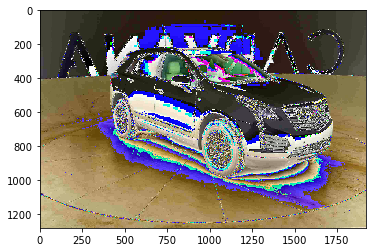

In [8]:
plt.imshow(x[22])
plt.show()

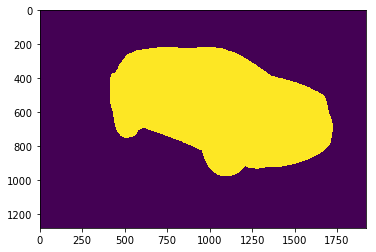

In [9]:
plt.imshow(np.squeeze(y[22],2))
plt.show()

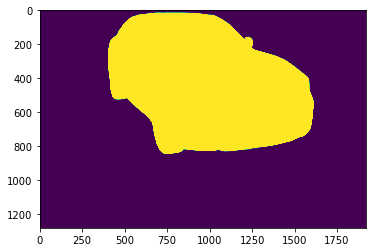

In [21]:
plt.imshow(np.squeeze(y_pred[22]))
plt.show()

In [17]:
y[0][600][1000]

1

In [14]:
x[1]

array([[[ 2.31060147,  2.27714515,  2.39869428],
        [ 2.31060147,  2.27714515,  2.39869428],
        [ 2.31060147,  2.27714515,  2.39869428],
        ..., 
        [ 2.13963819,  2.12437582,  2.15736294],
        [ 2.13963819,  2.12437582,  2.15736294],
        [ 2.13963819,  2.12437582,  2.15736294]],

       [[ 2.31060147,  2.27714515,  2.39869428],
        [ 2.31060147,  2.27714515,  2.39869428],
        [ 2.31060147,  2.27714515,  2.39869428],
        ..., 
        [ 2.13963819,  2.12437582,  2.15736294],
        [ 2.13963819,  2.12437582,  2.15736294],
        [ 2.13963819,  2.12437582,  2.15736294]],

       [[ 2.31060147,  2.27714515,  2.39869428],
        [ 2.31060147,  2.27714515,  2.39869428],
        [ 2.31060147,  2.27714515,  2.39869428],
        ..., 
        [ 2.13963819,  2.12437582,  2.15736294],
        [ 2.13963819,  2.12437582,  2.15736294],
        [ 2.13963819,  2.12437582,  2.15736294]],

       ..., 
       [[ 1.42159235,  1.41145194,  1.43336868],
        

In [14]:
from anti.keras_helper import ImagesAndMasks

In [15]:
obj = ImagesAndMasks(x_input, y_input, df_img_id)

In [16]:
x, y = obj.getData()

In [25]:
(x - 0) /(255 - 0)

array([[[[ 0.95686275,  0.95294118,  0.97254902],
         [ 0.95686275,  0.95294118,  0.97254902],
         [ 0.95686275,  0.95294118,  0.97254902],
         ..., 
         [ 0.91764706,  0.90196078,  0.90588235],
         [ 0.91764706,  0.90196078,  0.90588235],
         [ 0.91764706,  0.90196078,  0.90588235]],

        [[ 0.95686275,  0.95294118,  0.97254902],
         [ 0.95686275,  0.95294118,  0.97254902],
         [ 0.95686275,  0.95294118,  0.97254902],
         ..., 
         [ 0.91764706,  0.90196078,  0.90588235],
         [ 0.91764706,  0.90196078,  0.90588235],
         [ 0.91764706,  0.90196078,  0.90588235]],

        [[ 0.95686275,  0.95294118,  0.97254902],
         [ 0.95686275,  0.95294118,  0.97254902],
         [ 0.95686275,  0.95294118,  0.97254902],
         ..., 
         [ 0.91764706,  0.90196078,  0.90588235],
         [ 0.91764706,  0.90196078,  0.90588235],
         [ 0.91764706,  0.90196078,  0.90588235]],

        ..., 
        [[ 0.83137255,  0.83137255,